# AFM Digital Twin: Imperfect Probe Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/AFM/1_AFM_Imperfect_Probe_COLAB_Hackaton.ipynb)


## Task Overview

Participants are invited to develop methods for recovering the **"true" image** from SPM scans affected by probe artifacts, such as variable probe sizes and double tips.

---

### **Key Question**

> **Given a corrupted SPM image affected by probe artifacts, can we automatically detect these distortions and accurately reconstruct the original, undistorted image?**


# 1. Run server

In [1]:
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 33.0 MB/s eta 0:00:00
  Cloning https://github.com/pycroscopy/DTMicroscope.git (to revision boris_dev) to /tmp/pip-req-build-ow63b2wu
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/DTMicroscope.git /tmp/pip-req-build-ow63b2wu
  Running command git checkout -b boris_dev --track 

In [2]:
!run_server_afm

Server started and running in the background. Logs are being written to server.log.


# 2. Client side

In [3]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from IPython.display import clear_output, display

## 2.1 Get data

In [4]:
!wget https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5

--2025-12-11 18:18:52--  https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5 [following]
--2025-12-11 18:18:52--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22317256 (21M) [application/octet-stream]
Saving to: ‘dset_spm1.h5’

dset_spm1.h5        100%[===================>]  21.28M  --.-KB/s    in 0.1s    

2025-12-11 18:1

## 2.2 Register Data to the Digital twin

In [7]:
uri = "PYRO:microscope.server@localhost:9092" #port for the AFM DT 9092
mic_server = Pyro5.api.Proxy(uri)
import sys

if 'google.colab' in sys.modules:
    mic_server.initialize_microscope("AFM", data_path = r"dset_spm1.h5")
else:
    mic_server.initialize_microscope("AFM", data_path = "../test/datasets/dset_spm1.h5")
mic_server.setup_microscope(data_source = 'Compound_Dataset_1')#upload dataset?
mic_server.get_dataset_info()

[('channels',
  ['Channel_000',
   'Channel_001',
   'Channel_002',
   'Channel_003',
   'Channel_004',
   'Channel_005',
   'Channel_006']),
 ('signals',
  ['HeightRetrace',
   'Amplitude1Retrace',
   'Amplitude2Retrace',
   'Phase1Retrace',
   'Phase2Retrace',
   'FrequencyRetrace',
   'Response']),
 ('units', ['m', 'm', 'm', 'deg', 'deg', 'm', 'a.u.']),
 ('scans', [0, 1, 2, 3, 4, 5]),
 ('spectra', []),
 ('point_clouds', [6])]

## Artefact 0: Blunt 'needle' with an offset tip

In [8]:
#tip_radius
r_tip = np.random.uniform(0.2, 0.8)

#center (tip location)
center = [np.random.uniform(0.2, 0.8), np.random.uniform(0.2, 0.8)]

#kwargs for the blunt needle effect
kwargs = {'effect': 'real_tip', 'r_tip': r_tip, 'center': center}

#several effects can be combined in the mod_dict list
mod_dict = [{'effect': 'real_tip', 'kwargs': kwargs},]

Text(0.5, 1.0, 'Corrupted image')

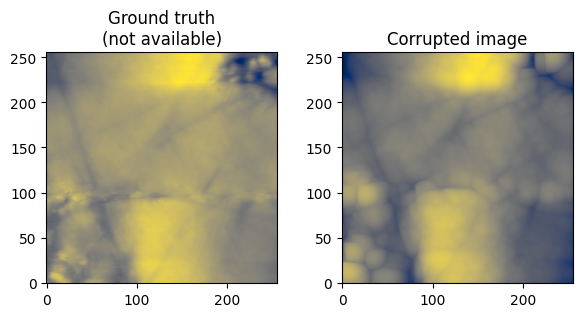

In [9]:
#scan without modification
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=None)
dat0 =  np.array(array_list, dtype=dtype).reshape(shape)
array_list, shape, dtype = mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat1 = np.array(array_list, dtype=dtype).reshape(shape)

fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat0[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Ground truth\n(not available)')
ax[1].imshow(dat1[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Corrupted image')

## Artefact 1: Tip doubling

In [10]:
# r_tip: Sizes of both tips in a double-tip needle configuration
# center: Positions of each tip in the double-tip needle
# length_coef: Relative lengths of each tip in the double-tip needle, indicating proximity to the surface

kwargs = {'r_tip': [0.1, 0.05], 'center': [[0.2, 0.5], [0.6, 0.55]], 'length_coef': [1, 0.8]}

mod_dict = [{'effect': 'tip_doubling', 'kwargs': kwargs},]

The attribute direction specifies the fast scanning axis, which can be either horizontal or vertical.

In [11]:
#ground truth scan topography
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=None)
dat =  np.array(array_list, dtype=dtype).reshape(shape)

# Corrupted scan topography with the fast scan axis oriented horizontally
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict, direction='horizontal')
dat0 =  np.array(array_list, dtype=dtype).reshape(shape)

# Corrupted scan topography with the fast scan axis oriented vertically
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict, direction='vertical')
dat1 =  np.array(array_list, dtype=dtype).reshape(shape)
dat1.shape

(1, 256, 256)

Text(0.5, 1.0, 'Tip doubling\nfast axis: vertical')

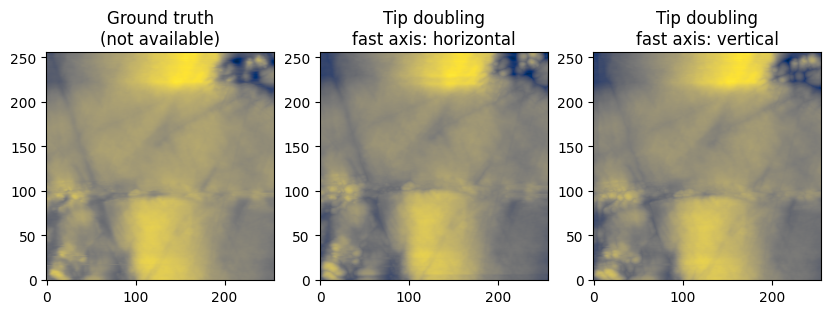

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Ground truth\n(not available)')
ax[1].imshow(dat0[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Tip doubling\nfast axis: horizontal')
ax[2].imshow(dat1[0].T, cmap='cividis', origin='lower')
ax[2].set_title('Tip doubling\nfast axis: vertical')